In [97]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = 'BY4741'
locus = 'FKS1-HS1'
pool_type = 'single'

# Notebook to classify variants using a Gaussian mixture model

This notebook currently supports:
- BY FKS1-HS1 NNK (+orthos)
- BY FKS1-HS2 NNK (+orthos)
- R1158 FKS1-HS1 NNK  - skip manually section to include missing mutants
- R1158 FKS2-HS1 NNK (+ orthos)
- R1158 FKS2-HS2 NNK (+ orthos)

## Import libraries

In [98]:
import os
import pandas as pd
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [99]:
aggdata_outpath = 'aggregated_data/'
missing_mut_path = 'aggregated_data/validation_DMS_missing_estimates.csv'
classified_outpath = 'aggregated_data/classified_variants/'
graph_outpath = 'manuscript_figures/'

## GMM

In [100]:
master = pd.read_csv(f'{aggdata_outpath}/master.csv', index_col=0)
slpNT = master[(master.strain == strain)
                   & (master.locus == locus)
                   & (master.pool_type == pool_type)
                  ].groupby(['compound','seq_type','Nham_aa','aa_seq','nt_seq']
                           )[['median_s','confidence_score']
                            ].agg(s = ('median_s', 'first'),
                                  cscore = ('confidence_score', 'first')
                                 ).reset_index()
slpNT

,compound,seq_type,Nham_aa,aa_seq,nt_seq,s,cscore
0,anidulafungin,WT,0.0,FLVLSLRDP,tttttagttttatctttgagagatcca,0.059886,1.0
1,anidulafungin,ortho,0.0,FLVLSLRDP,tttttggttttgtctttgagagatcca,0.042567,1.0
2,anidulafungin,ortho,1.0,FLILSLRDP,tttttgattttgtctttgagagatcca,-0.223979,1.0
3,anidulafungin,ortho,1.0,FLTLSLRDP,tttttgactttgtctttgagagatcca,0.127139,1.0
4,anidulafungin,ortho,2.0,FLALSFRDP,tttttggctttgtcttttagagatcca,0.370152,1.0
...,...,...,...,...,...,...,...
1259,none,single,1.0,TLVLSLRDP,acgttagttttatctttgagagatcca,-0.449800,1.0
1260,none,single,1.0,TLVLSLRDP,actttagttttatctttgagagatcca,0.033715,1.0
1261,none,single,1.0,VLVLSLRDP,gtgttagttttatctttgagagatcca,0.037623,1.0
1262,none,single,1.0,WLVLSLRDP,tggttagttttatctttgagagatcca,0.070207,1.0


In [101]:
slpNT.describe()

,Nham_aa,s,cscore
count,1264.000000,1264.000000,1264.000000
mean,1.319620,0.743967,1.056962
std,1.092287,0.910137,0.257737
min,0.000000,-1.144093,1.000000
25%,1.000000,0.011592,1.000000
50%,1.000000,0.140323,1.000000
75%,1.000000,1.805569,1.000000
max,7.000000,2.239924,3.000000


### Optimize model

In [102]:
GMMdf = slpNT
len(GMMdf)

1264

In [103]:
# Set specific seed
seed = 25 # Set value for repetability

# Initialize dictionary to store parameters for each condition
model_dict = {}

# Specify order of conditions
lcomp = ['none','dox','anidulafungin','caspofungin','micafungin']

# Optimize model for every condition (here, compound) separately
for j,c in enumerate(lcomp):
    if c in GMMdf.compound.unique():
        # The goal is to minimize AIC and BIC, but mostly BIC
        X = GMMdf[GMMdf.compound == c].s.values.reshape(-1,1)
        N = np.arange(1, 6)
        models = [None for i in range(len(N))] # testing up to 1-5 components
        # 5 is the max number of biologically relevant classes: deleterious, WT-like, intermediary, resistant, very resistant
        for i in range(len(N)):
            models[i] = GaussianMixture(n_components=N[i], random_state = seed).fit(X, y=None)

        # Compute AIC and BIC
        AIC = [m.aic(X) for m in models]
        BIC = [m.bic(X) for m in models]
    
        # Save parameters to dictionary
        model_dict[c.title()] = (N, AIC, BIC)

In [104]:
model_df = pd.DataFrame.from_dict(model_dict, orient='index', columns=['components','AIC','BIC']).reset_index(names='compound')
model_df = model_df.explode(['components','AIC','BIC']).melt(['compound','components'], var_name='IC')

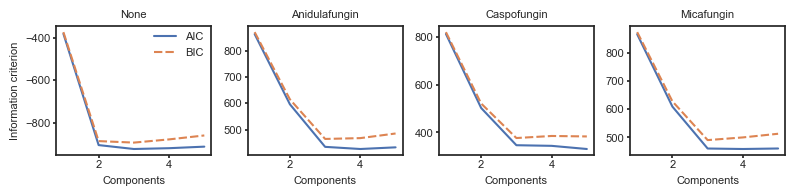

In [105]:
# Purge graph space
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(data=model_df, col='compound', x='components', y='value',
                  hue='IC', style='IC',
                  kind='line', height=2,
                  facet_kws = {'sharey':False, 'despine':False})

fig.set_titles(row_template='{row_name}', col_template='{col_name}')
fig.set_axis_labels('Components', 'Information criterion')
sns.move_legend(fig, 'upper left', bbox_to_anchor=(.175, .88), title=None)
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_GMM_BIC.svg', format='svg', dpi=300)

In [106]:
for c,y in model_dict.items(): # for each compound
    print(c, np.argmin(y[1])+1) # display the optimal number of components for the GMM

None 3
Anidulafungin 4
Caspofungin 5
Micafungin 4


### Run model

In [107]:
# Define the number of components (number of mods)
mods = 3

# Define range
mini = round(GMMdf.s.min()) -1
maxi = round(GMMdf.s.max())+1

# Initialize list of df
proba_list = []

for i,c in enumerate(model_dict.keys()): # For every compound
    X = GMMdf[GMMdf.compound == c.lower()].s.values.reshape(-1,1)
    M_best = GaussianMixture(n_components=mods, random_state = seed).fit(X, y=None)
    GMMdf.loc[GMMdf.compound == c.lower(), 'label'] = M_best.predict(X)
    
    x = np.linspace(mini, maxi, len(GMMdf[GMMdf.compound == c.lower()]))
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    # Convert to dataframe
    indiv_df = pd.DataFrame(pdf_individual)
    indiv_df['x'] = x
    indiv_df = indiv_df.melt(id_vars = 'x', var_name = 'label', value_name='p(x)')
    indiv_df['compound'] = c
    proba_list.append(indiv_df)

proba_df = pd.concat(proba_list, ignore_index=True)
hist_df = GMMdf.copy()
hist_df['compound'] = hist_df.compound.apply(lambda x: x.title())

In [108]:
stddf = pd.read_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/thresholds.csv')

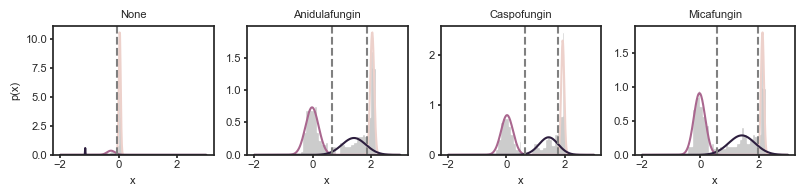

In [109]:
# Purge graph space
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(proba_df, col='compound',
                  x='x', y='p(x)', hue='label',
                  kind='line', height=2, legend=False,
                  facet_kws = {'sharey':False, 'despine':False}
                 )

fig.set_titles(row_template='{row_name}', col_template='{col_name}')

for i,c in enumerate(proba_df.compound.unique()):
    fig.axes[0][i].hist(hist_df[hist_df.compound == c].s,
                        30, density=True, histtype='stepfilled',
                        color='.8')
    fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[0], ls='--', color='grey')
    fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[1], ls='--', color='grey')
    
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_GMM_densities.svg', format='svg', dpi=300)

In [110]:
# Looking at the predicted labels for each condition and the median value to properly convert the label into a class
label_median = GMMdf.groupby(['compound', 'label'])[['s']].agg(['size','median']).reset_index().sort_values(by=[('compound',''),('s','median')])
label_median

compound label    s          
                        size    median
1   anidulafungin   1.0  132 -0.012576
2   anidulafungin   2.0   79  1.492155
0   anidulafungin   0.0  105  2.057751
4     caspofungin   1.0  129  0.005718
5     caspofungin   2.0   84  1.448548
3     caspofungin   0.0  103  1.930501
7      micafungin   1.0  141 -0.037772
8      micafungin   2.0   96  1.450873
6      micafungin   0.0   79  2.121986
11           none   2.0    1 -1.144093
10           none   1.0   38 -0.262749
9            none   0.0  277  0.038049

### Convert classification labels

In [111]:
class_dict = {}
class_list = ['WT-like', 'intermediary', 'resistant']
none_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
             'FKS1-HS2': ['WT-like', 'WT-like', 'WT-like'],
             'FKS2-HS1': ['slightly deleterious', 'WT-like', 'WT-like'],
             'FKS2-HS2': ['slightly deleterious', 'WT-like', 'WT-like']
            }
dox_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS2': ['deleterious', 'slightly deleterious', 'WT-like']
           }

for c in label_median.compound.unique():
    class_dict[c] = {}

i=0
for c,l in zip(label_median.compound, label_median.label):
    i = len(class_dict[c])
    if c in ['anidulafungin','caspofungin','micafungin']:
        class_dict[c][l] = class_list[i]
    elif c=='none':
        if locus in none_list.keys():
            class_dict[c][l] = none_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    elif c=='dox':
        if locus in dox_list.keys():
            class_dict[c][l] = dox_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    else:
        class_dict[c][l] = 'error'

class_dict

{'anidulafungin': {1.0: 'WT-like', 2.0: 'intermediary', 0.0: 'resistant'},
 'caspofungin': {1.0: 'WT-like', 2.0: 'intermediary', 0.0: 'resistant'},
 'micafungin': {1.0: 'WT-like', 2.0: 'intermediary', 0.0: 'resistant'},
 'none': {2.0: 'deleterious', 1.0: 'slightly deleterious', 0.0: 'WT-like'}}

In [112]:
GMMdf['rclass'] = GMMdf.apply(lambda row: class_dict[row.compound][row.label], axis=1)
GMMdf

,compound,seq_type,Nham_aa,aa_seq,nt_seq,s,cscore,label,rclass
0,anidulafungin,WT,0.0,FLVLSLRDP,tttttagttttatctttgagagatcca,0.059886,1.0,1.0,WT-like
1,anidulafungin,ortho,0.0,FLVLSLRDP,tttttggttttgtctttgagagatcca,0.042567,1.0,1.0,WT-like
2,anidulafungin,ortho,1.0,FLILSLRDP,tttttgattttgtctttgagagatcca,-0.223979,1.0,1.0,WT-like
3,anidulafungin,ortho,1.0,FLTLSLRDP,tttttgactttgtctttgagagatcca,0.127139,1.0,1.0,WT-like
4,anidulafungin,ortho,2.0,FLALSFRDP,tttttggctttgtcttttagagatcca,0.370152,1.0,1.0,WT-like
...,...,...,...,...,...,...,...,...,...
1259,none,single,1.0,TLVLSLRDP,acgttagttttatctttgagagatcca,-0.449800,1.0,1.0,slightly deleterious
1260,none,single,1.0,TLVLSLRDP,actttagttttatctttgagagatcca,0.033715,1.0,0.0,WT-like
1261,none,single,1.0,VLVLSLRDP,gtgttagttttatctttgagagatcca,0.037623,1.0,0.0,WT-like
1262,none,single,1.0,WLVLSLRDP,tggttagttttatctttgagagatcca,0.070207,1.0,0.0,WT-like


In [113]:
# Create output folder if it does not already exists
if not os.path.exists(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}'):
    os.makedirs(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}')

In [114]:
GMMdf.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/nt_raw_classification.csv')

## Breakdown: number of variants per class

In [115]:
GMMdf = pd.read_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/nt_raw_classification.csv', index_col=0)

In [116]:
GMMdf.groupby(['compound', 'rclass'])[['s']].agg(['size','median'])

s          
                                   size    median
compound      rclass                             
anidulafungin WT-like               132 -0.012576
              intermediary           79  1.492155
              resistant             105  2.057751
caspofungin   WT-like               129  0.005718
              intermediary           84  1.448548
              resistant             103  1.930501
micafungin    WT-like               141 -0.037772
              intermediary           96  1.450873
              resistant              79  2.121986
none          WT-like               277  0.038049
              deleterious             1 -1.144093
              slightly deleterious   38 -0.262749

## Refine classification (resolve overlaps)

To resolve overlaps at the nucleotide level, I use the distributions to define thresholds. However, because only the "resistant" and "WT-like" distributions (as called by the GMM) are narrow, we define the thresholds only for these groups. "Intermediary", "deleterious", etc end up being the label of variants which **did not** cross the thresholds.

In order to have a single class per aminoacid variant, we reapply the thresholds on the aggregated dataframe

### Step 1 - Set thresholds from narrow distributions

In [117]:
zthresh = 3 # set threshold in z-score

In [118]:
distri_params = GMMdf.groupby(['compound','rclass'])[['s']].agg(['mean','std']).reset_index()
distri_params.columns = [x[0] if x[1]=='' else x[1] for x in distri_params.columns]
distri_params['lower_bound'] = distri_params['mean'] - zthresh*distri_params['std']
distri_params['upper_bound'] = distri_params['mean'] + zthresh*distri_params['std']
distri_params

,compound,rclass,mean,std,lower_bound,upper_bound
0,anidulafungin,WT-like,-0.013664,0.226409,-0.692890,0.665562
1,anidulafungin,intermediary,1.398613,0.365794,0.301232,2.495995
2,anidulafungin,resistant,2.044907,0.063072,1.855692,2.234123
3,caspofungin,WT-like,0.022527,0.207676,-0.600500,0.645554
4,caspofungin,intermediary,1.413736,0.296348,0.524693,2.302779
5,caspofungin,resistant,1.926463,0.051259,1.772685,2.080240
6,micafungin,WT-like,-0.029174,0.195351,-0.615226,0.556878
7,micafungin,intermediary,1.396550,0.413320,0.156589,2.636511
8,micafungin,resistant,2.125015,0.051190,1.971445,2.278586
9,none,WT-like,0.038281,0.032359,-0.058796,0.135357


In [119]:
stdlist = []

for c in distri_params.compound.unique():
    if c in ['caspofungin','micafungin','anidulafungin']:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'upper_bound'
                                         ].values[0]
                       ])
        if locus in ['FKS1-HS1','FKS2-HS1']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'resistant'),
                                              'lower_bound'
                                             ].values[0]                    
                           ])
        elif locus in ['FKS1-HS2','FKS2-HS2']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'intermediary'),
                                              'upper_bound'
                                             ].values[0]
                           ])
        else:
            print('Please define locus-specific bound')
    else:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'lower_bound'
                                         ].values[0]
                       ])
        stdlist.append([c, 'up', None])
    
stddf = pd.DataFrame(stdlist, columns=['compound', 'thresh', 'val'])
stddf.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/thresholds.csv')
stddf

,compound,thresh,val
0,anidulafungin,low,0.665562
1,anidulafungin,up,1.855692
2,caspofungin,low,0.645554
3,caspofungin,up,1.772685
4,micafungin,low,0.556878
5,micafungin,up,1.971445
6,none,low,-0.058796
7,none,up,NaN


<Axes: xlabel='compound', ylabel='s'>

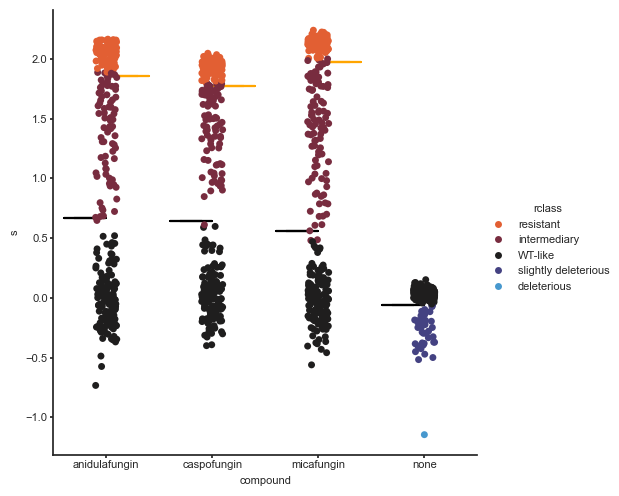

In [120]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='rclass',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

### Step 2 - Refine classification for all nucleotide variants

In [121]:
def refine_class(v, comp, threshdf):
    wtbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'low'),
                           'val'].values[0]
    resbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'up'),
                           'val'].values[0]
    
    if (comp in ['none','dox']) & (v > -.8):
        if (v >= wtbound):
            return 'WT-like'
        else:
            return 'slightly deleterious'
    elif (comp in ['none','dox']) & (v < -.8):
        return 'deleterious'
    else:        
        if v <= wtbound:
            return 'WT-like'
        elif v >= resbound:
            return 'resistant'
        else:
            return 'intermediary'

In [122]:
GMMdf['refined_class'] = GMMdf.apply(lambda row: refine_class(row.s, row.compound, stddf), axis=1)
GMMdf

,compound,seq_type,Nham_aa,aa_seq,nt_seq,s,cscore,label,rclass,refined_class
0,anidulafungin,WT,0.0,FLVLSLRDP,tttttagttttatctttgagagatcca,0.059886,1.0,1.0,WT-like,WT-like
1,anidulafungin,ortho,0.0,FLVLSLRDP,tttttggttttgtctttgagagatcca,0.042567,1.0,1.0,WT-like,WT-like
2,anidulafungin,ortho,1.0,FLILSLRDP,tttttgattttgtctttgagagatcca,-0.223979,1.0,1.0,WT-like,WT-like
3,anidulafungin,ortho,1.0,FLTLSLRDP,tttttgactttgtctttgagagatcca,0.127139,1.0,1.0,WT-like,WT-like
4,anidulafungin,ortho,2.0,FLALSFRDP,tttttggctttgtcttttagagatcca,0.370152,1.0,1.0,WT-like,WT-like
...,...,...,...,...,...,...,...,...,...,...
1259,none,single,1.0,TLVLSLRDP,acgttagttttatctttgagagatcca,-0.449800,1.0,1.0,slightly deleterious,slightly deleterious
1260,none,single,1.0,TLVLSLRDP,actttagttttatctttgagagatcca,0.033715,1.0,0.0,WT-like,WT-like
1261,none,single,1.0,VLVLSLRDP,gtgttagttttatctttgagagatcca,0.037623,1.0,0.0,WT-like,WT-like
1262,none,single,1.0,WLVLSLRDP,tggttagttttatctttgagagatcca,0.070207,1.0,0.0,WT-like,WT-like


<Axes: xlabel='compound', ylabel='s'>

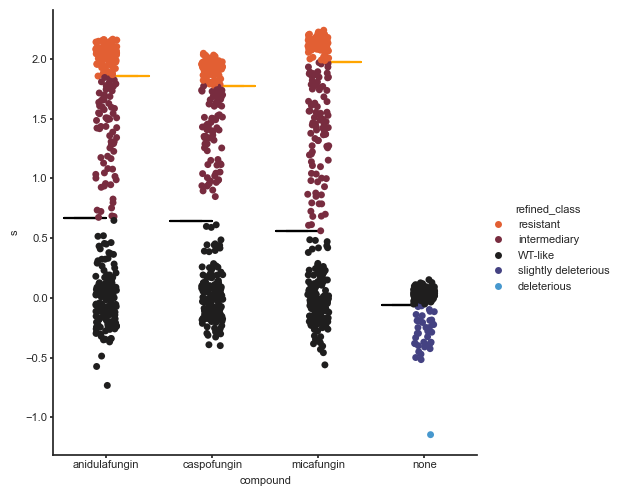

In [123]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='refined_class',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

In [124]:
GMMdf.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/nt_refined_classification.csv')

### Step 3 - Classify aminoacid variants

In [125]:
slpAA = GMMdf.groupby(['compound','seq_type','Nham_aa','aa_seq']
                         )[['s','cscore']
                          ].agg(s = ('s', 'median'),
                                cscore = ('cscore', 'min')).reset_index()

Here I'm adding a little snippet to include FKS1-HS1 mutants originally missing from the DMS dataset but that were individually reconstructed and for which we have an inferred DMS score

In [126]:
missmut = pd.read_csv(missing_mut_path, index_col=0)[['compound','aa_seq','estimated_s']]
missmut.rename(columns={'estimated_s':'s'}, inplace=True)
missmut['seq_type'] = 'single'
missmut['Nham_aa'] = 1
missmut['cscore'] = 1
missmut.head(4)

,compound,aa_seq,s,seq_type,Nham_aa,cscore
8,anidulafungin,CLVLSLRDP,2.009071,single,1,1
9,caspofungin,CLVLSLRDP,1.918283,single,1,1
10,micafungin,CLVLSLRDP,1.941420,single,1,1
11,none,CLVLSLRDP,0.122445,single,1,1


In [127]:
# Replacing the two DMS datapoints which were overestimated to replace by validation data
# Note: even though values obtained with caspofungin and anidulafungin were very well correlated, we still replace with the inferred score + that way we don't have duplicate values in the df
slpAA.drop(slpAA[slpAA.aa_seq.isin(missmut.aa_seq.unique())].index, inplace=True)

In [128]:
if locus == 'FKS1-HS1':
    slpAA = pd.concat([slpAA, missmut], ignore_index=True)
elif locus in ['FKS1-HS2','FKS2-HS2']:
    print('No mutants added')
else:
    print('Locus not supported')
slpAA

,compound,seq_type,Nham_aa,aa_seq,s,cscore
0,anidulafungin,WT,0.0,FLVLSLRDP,0.059886,1.0
1,anidulafungin,ortho,0.0,FLVLSLRDP,0.042567,1.0
2,anidulafungin,ortho,1.0,FLILSLRDP,-0.223979,1.0
3,anidulafungin,ortho,1.0,FLTLSLRDP,0.127139,1.0
4,anidulafungin,ortho,2.0,FLALSFRDP,0.370152,1.0
...,...,...,...,...,...,...
919,none,single,1.0,FLVLSLRDQ,0.007008,1.0
920,anidulafungin,single,1.0,FLWLSLRDP,1.445682,1.0
921,caspofungin,single,1.0,FLWLSLRDP,1.040897,1.0
922,micafungin,single,1.0,FLWLSLRDP,0.903476,1.0


In [129]:
slpAA['refined_class'] = slpAA.apply(lambda row: refine_class(row.s, row.compound, stddf), axis=1)

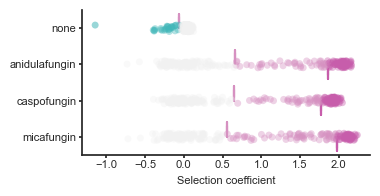

In [130]:
# Purge graph space
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

lclasses = ['resistant','intermediary','WT-like','slightly deleterious','deleterious']
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

fig = sns.catplot(slpAA, x='s', y='compound', order=['none','anidulafungin','caspofungin','micafungin'],
                  hue='refined_class', hue_order=lclasses, palette=custom_palette, height=2, aspect=2,
                  alpha=.4, legend=False
                 )

sns.boxplot(stddf, x='val', y='compound',
            hue='thresh', hue_order=['low','up'], palette=['#D691C1','#C75DAB'], fill=False,
            legend=False)

fig.set(xlabel='Selection coefficient', ylabel='')
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_classification_stripplot.svg', format='svg', dpi=300)

In [131]:
# Convert to 2 levels only = sensitive or resistant
slpAA['sensres'] = slpAA.refined_class.replace({'intermediary':'resistant',
                                                'WT-like':'sensitive', 'slightly deleterious':'sensitive', 'deleterious':'sensitive'})
slpAA

,compound,seq_type,Nham_aa,aa_seq,s,cscore,refined_class,sensres
0,anidulafungin,WT,0.0,FLVLSLRDP,0.059886,1.0,WT-like,sensitive
1,anidulafungin,ortho,0.0,FLVLSLRDP,0.042567,1.0,WT-like,sensitive
2,anidulafungin,ortho,1.0,FLILSLRDP,-0.223979,1.0,WT-like,sensitive
3,anidulafungin,ortho,1.0,FLTLSLRDP,0.127139,1.0,WT-like,sensitive
4,anidulafungin,ortho,2.0,FLALSFRDP,0.370152,1.0,WT-like,sensitive
...,...,...,...,...,...,...,...,...
919,none,single,1.0,FLVLSLRDQ,0.007008,1.0,WT-like,sensitive
920,anidulafungin,single,1.0,FLWLSLRDP,1.445682,1.0,intermediary,resistant
921,caspofungin,single,1.0,FLWLSLRDP,1.040897,1.0,intermediary,resistant
922,micafungin,single,1.0,FLWLSLRDP,0.903476,1.0,intermediary,resistant


In [132]:
slpAA.drop(slpAA[(slpAA.Nham_aa == 0) & (slpAA.seq_type != 'single')].index, inplace=True)
slpAA.reset_index(drop=True, inplace=True)

In [133]:
slpAA.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/aa_refined_classification.csv')

### Step 4 - Keep info from all nucleotide variants but refined class is the one from aminoacid variants

This is useful to display error bars on our plot for validations. Each dot is an aminoacid variant colored by the refined class, but the error bars correspond to the 1st and 3rd quartiles obtained across nucleotide variants (encoding the given aminoacid sequence).

In [134]:
# The following merge operation automatically excludes all WT instances except the ones of seq_type == 'single', which correspond to median of synonymous mutants (only 1 mutated codon), excluding the WT nucleotide sequence
lcols = ['compound','seq_type','Nham_aa','aa_seq']
GMMdf = GMMdf.merge(right=slpAA[lcols+['refined_class']].rename(columns={'refined_class':'aa_class'}), on=lcols)

In [135]:
GMMdf.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/nt_refined_classification.csv')

### Counts / %

In [49]:
counts = slpAA[slpAA.cscore <3].groupby(['seq_type','compound','sensres']).aa_seq.nunique().to_frame().reset_index()
tots = slpAA[slpAA.cscore <3].groupby('seq_type').aa_seq.nunique().to_frame(name='totals').reset_index()
perc = pd.merge(left=counts, right=tots, on='seq_type')
perc['%'] = perc.apply(lambda row: f'{row.aa_seq/row.totals:.1%}', axis=1)
perc

,seq_type,compound,sensres,aa_seq,totals,%
0,ortho,anidulafungin,resistant,3,62,4.8%
1,ortho,anidulafungin,sensitive,59,62,95.2%
2,ortho,caspofungin,resistant,6,62,9.7%
3,ortho,caspofungin,sensitive,56,62,90.3%
4,ortho,dox,sensitive,62,62,100.0%
5,ortho,micafungin,resistant,2,62,3.2%
6,ortho,micafungin,sensitive,60,62,96.8%
7,ortho,none,sensitive,62,62,100.0%
8,single,anidulafungin,resistant,22,125,17.6%
9,single,anidulafungin,sensitive,103,125,82.4%


### Show distributions only for high confidence single mutants

In [50]:
slpAA = pd.read_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/aa_refined_classification.csv', index_col=0)

In [51]:
graphdf = slpAA[(slpAA.Nham_aa <=1) & (slpAA.cscore < 3)]

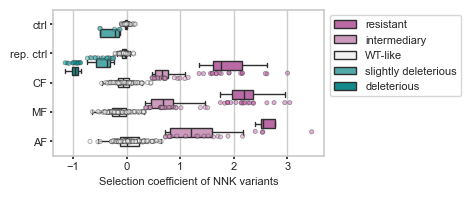

In [52]:
list_drugs = ['none','dox','caspofungin','micafungin','anidulafungin']
abrev_drugs = {'none':'ctrl',
               'dox':'rep. ctrl',
               'caspofungin':'CF',
               'micafungin':'MF',
               'anidulafungin':'AF'
              }
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

sns.set(rc = {'figure.figsize':(3.5,1.9),
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2
             },
       style='whitegrid')

fig = sns.boxplot(graphdf, x='s', y='compound', hue='refined_class',
                  order=[x for x in list_drugs if x in graphdf.compound.unique()],
                  hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
                  palette=custom_palette, fliersize=0,
                  width=1.5, # Width will draw wider boxes but strips have to be realigned manually
                 )
sns.stripplot(graphdf, x='s', y='compound', hue='refined_class',
              order=[x for x in list_drugs if x in graphdf.compound.unique()],
              hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
              palette=custom_palette,
              dodge=True, alpha=.5, s=3, linewidth=.5,
              legend=False
             )

fig.set_yticks(np.arange(0,len(graphdf.compound.unique())),
               [abrev_drugs[x] for x in list_drugs if x in graphdf.compound.unique()],
              )

fig.set(xlabel='Selection coefficient of NNK variants', ylabel='')
fig.legend(bbox_to_anchor=(1,1), title=None)
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_distribution_effects.svg', format='svg', dpi=300)

### Rug plot with separate panels

This version means to highlight overall distributions, as well as separate the impact on protein function (none) from the impact on resistance

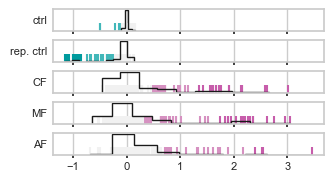

In [53]:
list_drugs = ['none','dox','caspofungin','micafungin','anidulafungin']
abrev_drugs = {'none':'ctrl',
               'dox':'rep. ctrl',
               'caspofungin':'CF',
               'micafungin':'MF',
               'anidulafungin':'AF'
              }
lclasses = ['resistant','intermediary','WT-like','slightly deleterious','deleterious']
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

rc_dict = {'figure.figsize':(3.5,1.9),
      'font.family':'Arial',
      'font.size':8,
      'legend.title_fontsize':8, 'legend.fontsize':8,
      'axes.labelsize':8,'axes.titlesize':8,
      'xtick.labelsize':8, 'ytick.labelsize':8,
      'xtick.major.pad':2, 'ytick.major.pad':2,
      'xtick.bottom': True, 'ytick.left': False,
      'xtick.major.size':2, 'ytick.major.size':2
     }
plt.rcParams.update(rc_dict)
fig, ax = plt.subplots(len(graphdf.compound.unique()),1, sharex=True,
                       gridspec_kw = {'hspace':.4})

for i, c in enumerate([x for x in list_drugs if x in graphdf.compound.unique()]):
    axdf = graphdf[graphdf.compound == c]
    ax[i].hist(axdf.s, histtype='step', color='k')
    ax[i].scatter(axdf.s, np.zeros(axdf.s.shape), marker=2, c=axdf.refined_class.map(dict(zip(lclasses, custom_palette))))
    ax[i].set_yticks([])
    ax[i].set_ylabel(abrev_drugs[c], rotation=0, ha='right', va='center')

plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_distribution_effects_rug.svg', format='svg', dpi=300)

### Show distributions only for high confidence ortho mutants

In [54]:
graphdf = slpAA[(slpAA.Nham_aa >=2) & (slpAA.cscore < 3)]

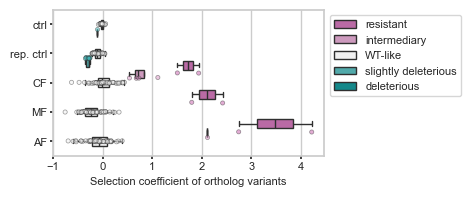

In [55]:
list_drugs = ['none','dox','caspofungin','micafungin','anidulafungin']
abrev_drugs = {'none':'ctrl',
               'dox':'rep. ctrl',
               'caspofungin':'CF',
               'micafungin':'MF',
               'anidulafungin':'AF'
              }
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

sns.set(rc = {'figure.figsize':(3.5,1.9),
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2
             },
       style='whitegrid')

fig = sns.boxplot(graphdf, x='s', y='compound', hue='refined_class',
                  order=[x for x in list_drugs if x in graphdf.compound.unique()],
                  hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
                  palette=custom_palette, fliersize=0,
                  width=1.5, # Width will draw wider boxes but strips have to be realigned manually
                 )
sns.stripplot(graphdf, x='s', y='compound', hue='refined_class',
              order=[x for x in list_drugs if x in graphdf.compound.unique()],
              hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
              palette=custom_palette,
              dodge=True, alpha=.5, s=3, linewidth=.5,
              legend=False
             )

fig.set_yticks(np.arange(0,len(graphdf.compound.unique())),
               [abrev_drugs[x] for x in list_drugs if x in graphdf.compound.unique()],
              )

fig.set(xlabel='Selection coefficient of ortholog variants', ylabel='')
fig.legend(bbox_to_anchor=(1,1), title=None)
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_ortho_distribution_effects.svg', format='svg', dpi=300)

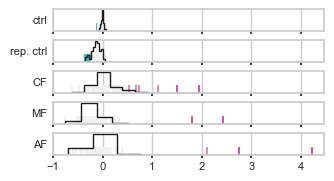

In [56]:
list_drugs = ['none','dox','caspofungin','micafungin','anidulafungin']
abrev_drugs = {'none':'ctrl',
               'dox':'rep. ctrl',
               'caspofungin':'CF',
               'micafungin':'MF',
               'anidulafungin':'AF'
              }
lclasses = ['resistant','intermediary','WT-like','slightly deleterious','deleterious']
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

rc_dict = {'figure.figsize':(3.5,1.9),
      'font.family':'Arial',
      'font.size':8,
      'legend.title_fontsize':8, 'legend.fontsize':8,
      'axes.labelsize':8,'axes.titlesize':8,
      'xtick.labelsize':8, 'ytick.labelsize':8,
      'xtick.major.pad':2, 'ytick.major.pad':2,
      'xtick.bottom': True, 'ytick.left': False,
      'xtick.major.size':2, 'ytick.major.size':2
     }
plt.rcParams.update(rc_dict)
fig, ax = plt.subplots(len(graphdf.compound.unique()),1, sharex=True,
                       gridspec_kw = {'hspace':.4})

for i, c in enumerate([x for x in list_drugs if x in graphdf.compound.unique()]):
    axdf = graphdf[graphdf.compound == c]
    ax[i].hist(axdf.s, histtype='step', color='k')
    ax[i].scatter(axdf.s, np.zeros(axdf.s.shape), marker=2, c=axdf.refined_class.map(dict(zip(lclasses, custom_palette))))
    ax[i].set_yticks([])
    ax[i].set_ylabel(abrev_drugs[c], rotation=0, ha='right', va='center')

plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_ortho_distribution_effects_rug.svg', format='svg', dpi=300)

## UpSet plot on classified variants

In [47]:
upsetdf = slpAA[(slpAA.Nham_aa <=1) & (slpAA.cscore < 3)]

In [48]:
parse_dict = {'resistant':True, 'sensitive':False}

In [49]:
BYnnkCompWide = upsetdf.pivot_table(index='aa_seq',
                                    columns='compound',
                                    values=['s','sensres'],
                                    aggfunc='first'
                                   ).reset_index()
BYnnkCompWide['max_s'] = BYnnkCompWide['s'].max(axis=1)
bincat = BYnnkCompWide['sensres'].replace(parse_dict)
bincat.rename(columns={'anidulafungin':'AF',
                       'caspofungin':'CF',
                       'micafungin':'MF',
                       'none':'ctrl'
                      }, inplace=True)
compounds = bincat.columns.tolist()
bincat = pd.concat([bincat, BYnnkCompWide[['max_s']].droplevel(1, axis=1)], axis=1)
bincat

,AF,CF,dox,MF,ctrl,max_s
0,False,False,False,True,False,0.448349
1,True,True,False,True,False,1.305855
2,True,True,False,True,False,1.214658
3,False,False,False,True,False,0.630822
4,False,False,False,True,False,0.703303
...,...,...,...,...,...,...
130,False,False,False,False,False,0.136393
131,True,True,False,True,False,1.457989
132,False,False,False,False,False,-0.005603
133,False,False,False,False,False,0.144368


In [50]:
bincat.ctrl.unique()

array([False])

In [51]:
bincat.to_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/upsetplot.csv')

In [52]:
bincat = pd.read_csv(f'{classified_outpath}/{"_".join([strain,locus,pool_type])}/upsetplot.csv', index_col=0)

No support for this hotspot


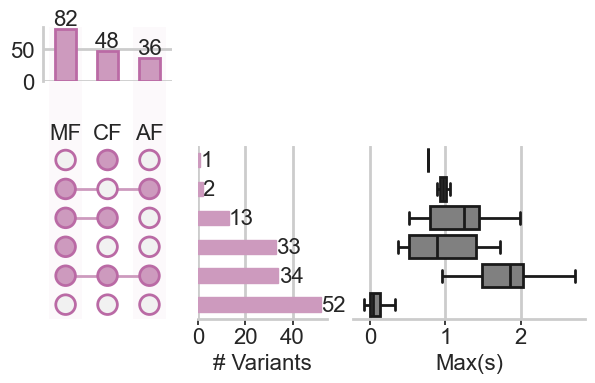

In [55]:
# Manuscript version
# For this plot, all sizes are doubled and the graph is ultimately reduced by 50% for the final panel

rc_dict = {'font.family':'Arial',
           'font.size':16,
           'axes.linewidth': 2, 'grid.linewidth': 2,
           'axes.labelsize':16,'axes.titlesize':16,
           'xtick.labelsize':16, 'ytick.labelsize':16,
           'xtick.major.pad':2, 'ytick.major.pad':2,
           'xtick.major.size':4, 'ytick.major.size':4
          }

upset_obj = UpSet(from_indicators(compounds, data=bincat),
                  orientation='vertical',
                  facecolor='#cd9abe', other_dots_color='#F1F1F1',
                  #show_percentages=True,
                  show_counts=True,
                  #min_subset_size=10,
                  sort_by='cardinality',
                  element_size=None,
                  intersection_plot_elements=3, # height/width of intersection barplot in matrix elements # needs to be 0 to be able to draw stacked_barplot
                  totals_plot_elements = 2, # width/height of totals barplot in matrix elements
                 )

upset_obj.add_catplot(value='max_s', kind='box',
                      color='grey', fliersize=3, linewidth=2, linecolor='k',
                      elements=5 # height in number of matrix elements
                      )

fig = plt.figure(figsize=(7, 3.8))

with plt.rc_context(rc_dict):
    d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()

axt = d['totals']
axm = d['matrix']
ax0 = d['intersections'] # Key corresponding to stacked barplot ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to additional plot, in this case catplot

for i in [0,1,2]:
    axt.get_children()[i].set_color('#cd9abe')
    axt.get_children()[i].set_edgecolor('#ba6aa5')
    axt.get_children()[i].set_linewidth(2)

axm.set_xticklabels(axm.get_xticklabels(), rotation=0, ha='center')
axm.get_children()[0].set_edgecolor('#ba6aa5')
axm.get_children()[0].set_linewidth(2)

ax0.set_xlabel('# Variants') # (unique aminoacid sequences)
ax1.set_xlabel('Max(s)')

if locus=='FKS1-HS1':
    for i in [0,1,2,3,4,5,6,7]:
        ax0.get_children()[i].set_linewidth(2)
        if i <=5:
            ax0.get_children()[i].set_color('grey')
            ax0.get_children()[i].set_edgecolor('k')
        elif i==6:
            ax0.get_children()[i].set_color('#F1F1F1')
            ax0.get_children()[i].set_edgecolor('#b0b0b0')
        else:
            ax0.get_children()[i].set_edgecolor('#ba6aa5')
    
    ax1.get_children()[42].set_facecolor('#F1F1F1')
    ax1.get_children()[49].set_facecolor('#cd9abe')

elif locus=='FKS1-HS2':
    for i in [0,1,2,3,4,5,6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <=4:
            ax0.get_children()[i].set_color('grey')
            ax0.get_children()[i].set_edgecolor('k')
        elif i==5:
            ax0.get_children()[i].set_edgecolor('#ba6aa5')
        else:
            ax0.get_children()[i].set_color('#F1F1F1')
            ax0.get_children()[i].set_edgecolor('#b0b0b0')
    ax1.get_children()[35].set_facecolor('#cd9abe')
    ax1.get_children()[42].set_facecolor('#F1F1F1')

else:
    print('No support for this hotspot')

plt.savefig(f'{graph_outpath}/upsetplot_resistance_overlap_{strain}_{locus}.svg', format='svg', dpi=300)